In [37]:
"Importing Libraries"
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet import ResNet101, ResNet152
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet 
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras import backend as K
from keras import optimizers
from keras import losses
from keras.optimizers import SGD, Adam
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D,MaxPool2D , GlobalAveragePooling2D , AveragePooling2D , BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import cohen_kappa_score , matthews_corrcoef , classification_report , roc_auc_score , accuracy_score
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import argparse
import random, glob
import os, sys, csv
import cv2
import time, datetime

In [ ]:
"Loading the dataset from directory"
directory_1 = r"C:\Users\Abinaya Ravichandran\Desktop\Fall 2020\ECE613\Research Project\Detecting_Covid19_CT_Scan\COVID"
directory_2 = r"C:\Users\Abinaya Ravichandran\Desktop\Fall 2020\ECE613\Research Project\Detecting_Covid19_CT_Scan\NORMAL"

In [11]:
"Initializing variables"
x1=[]
x_ = list()
Y = []
y = list()
c = 0
nc = 0

In [ ]:
"COVID Dataset"
for filename in os.listdir(directory_1):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        try:
            path = os.path.join(directory_1, filename)
            img = cv2.imread(path)
            img_ = cv2.resize(img,(224,224))
            img_arr = np.asarray(img_)
            x_.append(img_arr)
            label = 0
            c = c+1
        except:
            None

In [ ]:
"NORMAL Dataset"
for filename in os.listdir(directory_2):
    if filename.endswith(".png") or filename.endswith(".jpg"):
#       print(os.path.join(directory, filename))
        try:
            path = os.path.join(directory_2, filename)
            img = cv2.imread(path)
            img_ = cv2.resize(img,(224,224))
            img_arr = np.asarray(img_)
            x_.append(img_arr)
            label = 1
            nc = nc+1
        except:
            None

In [2]:
"Assinging lable to image datframe"
for item in x_:
    if len(item.shape) > 2 and item.shape[2] == 4:
        item = cv2.cvtColor(item, cv2.COLOR_BGRA2BGR)
    x1.append(item)
    
"Covid Images"
for i in range(350):
    Y.append(1)
# print(Y)

"Normal Images"
for i in range(350):
    Y.append(0)
# print(Y)   

"Converting images to numpy array"
X = np.asarray(x1)
y = np.asarray(Y)
y = to_categorical(y,num_classes = 2)
# print(X.shape)

In [4]:
"Spliting data into Train, Test and Validation"
X_train,x_test,y_train,y_test = train_test_split(*shuffle(X, y),test_size = 0.10,random_state = 42)
X_train,x_val,y_train,y_val = train_test_split(*shuffle(X_train, y_train),test_size = 0.10,random_state = 42)

In [9]:
"Functions to print evalution matrices"

def print_confusion_matrix():
    matrix = confusion_matrix(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1))
    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(matrix,cmap='Blues',linecolor='white',linewidths=1,annot=True,fmt='d')
    ax.set_ylim(sorted(ax.get_xlim(), reverse=True))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_model_accuracy_loss():
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy (Train)')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy (Val)')
    plt.plot(history.history['loss'], 'r--', label='Loss of (Train)')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of (Val)')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Epochs')
    plt.ylim(0)
    plt.legend()
    plt.show()

def print_performance_metrics():
    print('Accuracy (Test):', np.round(metrics.accuracy_score(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1)),4))
    print('Precision Score:', np.round(metrics.precision_score(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1),average='weighted'),4))
    print('Recall Score:', np.round(metrics.recall_score(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1),average='weighted'),4))
    print('F1 Score:', np.round(metrics.f1_score(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1),average='weighted'),4))
    print('ROC AUC:',np.round(roc_auc_score(y_test.argmax(axis=1),max_y_pred_test.argmax(axis=1)),4)) 
    print( metrics.classification_report(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1)))

### **VGG-19 Model**

In [10]:
baseModel = VGG19(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
    layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)

Train on 510 samples, validate on 57 samples
Epoch 1/20
510/510 [==============================] - 64s 125ms/step - loss: 1.4703 - accuracy: 0.6000 - val_loss: 0.9316 - val_accuracy: 0.7368
Epoch 2/20
510/510 [==============================] - 69s 136ms/step - loss: 0.6339 - accuracy: 0.7716 - val_loss: 0.8971 - val_accuracy: 0.6754
Epoch 3/20
510/510 [==============================] - 68s 132ms/step - loss: 0.3538 - accuracy: 0.8549 - val_loss: 0.8480 - val_accuracy: 0.6930
Epoch 4/20
510/510 [==============================] - 68s 133ms/step - loss: 0.2426 - accuracy: 0.9010 - val_loss: 0.9328 - val_accuracy: 0.7018
Epoch 5/20
510/510 [==============================] - 69s 134ms/step - loss: 0.1889 - accuracy: 0.9265 - val_loss: 0.8292 - val_accuracy: 0.7281
Epoch 6/20
510/510 [==============================] - 68s 133ms/step - loss: 0.1753 - accuracy: 0.9333 - val_loss: 0.8688 - val_accuracy: 0.7281
Epoch 7/20
510/510 [==============================] - 68s 132ms/step - loss: 0.1189 -

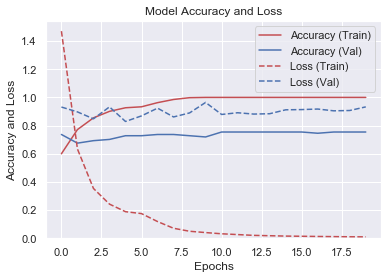

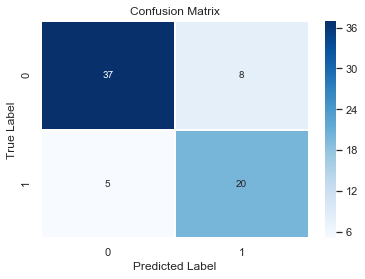

Accuracy Score (Test): 0.8143
Precision Score: 0.8214
Recall Score: 0.8143
F1 Score: 0.8163
Cohen Kappa Score: 0.6061
Matthews Corrcoef: 0.6086
ROC AUC Score: 0.8111
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        45
           1       0.71      0.80      0.75        25

    accuracy                           0.81        70
   macro avg       0.80      0.81      0.80        70
weighted avg       0.82      0.81      0.82        70



In [11]:
y_pred_test = model.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **VGG-16 Model**

In [12]:
baseModel = VGG16(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model2 = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
    layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model2.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model2.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)

Train on 510 samples, validate on 57 samples
Epoch 1/20
510/510 [==============================] - 53s 104ms/step - loss: 1.4474 - accuracy: 0.5873 - val_loss: 0.9376 - val_accuracy: 0.6053
Epoch 2/20
510/510 [==============================] - 54s 106ms/step - loss: 0.8179 - accuracy: 0.7127 - val_loss: 0.8816 - val_accuracy: 0.7018
Epoch 3/20
510/510 [==============================] - 54s 107ms/step - loss: 0.5229 - accuracy: 0.7902 - val_loss: 0.7065 - val_accuracy: 0.7193
Epoch 4/20
510/510 [==============================] - 55s 107ms/step - loss: 0.3191 - accuracy: 0.8598 - val_loss: 0.6270 - val_accuracy: 0.7105
Epoch 5/20
510/510 [==============================] - 56s 109ms/step - loss: 0.2060 - accuracy: 0.9255 - val_loss: 0.5890 - val_accuracy: 0.7719
Epoch 6/20
510/510 [==============================] - 55s 108ms/step - loss: 0.1418 - accuracy: 0.9588 - val_loss: 0.5668 - val_accuracy: 0.7456
Epoch 7/20
510/510 [==============================] - 55s 108ms/step - loss: 0.1039 -

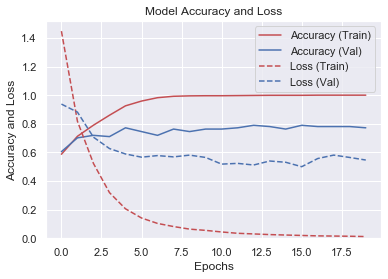

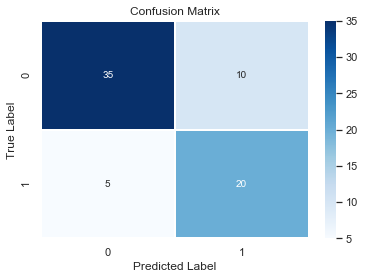

Accuracy Score (Test): 0.7857
Precision Score: 0.8006
Recall Score: 0.7857
F1 Score: 0.7892
Cohen Kappa Score: 0.5532
Matthews Corrcoef: 0.5594
ROC AUC Score: 0.7889
              precision    recall  f1-score   support

           0       0.88      0.78      0.82        45
           1       0.67      0.80      0.73        25

    accuracy                           0.79        70
   macro avg       0.77      0.79      0.78        70
weighted avg       0.80      0.79      0.79        70



In [13]:
y_pred_test = model2.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **ResNet50 Model**

In [14]:
baseModel = ResNet50(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(32, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model3 = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
    layer.trainable = False
model3.compile(loss="binary_crossentropy", optimizer='adam',metrics=["accuracy"])

history= model3.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 29s 0us/step
Train on 510 samples, validate on 57 samples
Epoch 1/20
510/510 [==============================] - 72s 141ms/step - loss: 0.5946 - accuracy: 0.6569 - val_loss: 0.6162 - val_accuracy: 0.6667
Epoch 2/20
510/510 [==============================] - 70s 138ms/step - loss: 0.3693 - accuracy: 0.8471 - val_loss: 0.7433 - val_accuracy: 0.6228
Epoch 3/20
510/510 [==============================] - 70s 137ms/step - loss: 0.2327 - accuracy: 0.9245 - val_loss: 0.6332 - val_accuracy: 0.7193
Epoch 4/20
510/510 [==============================] - 68s 134ms/step - loss: 0.2003 - accuracy: 0.9118 - val_loss: 1.1950 - val_accuracy: 0.5965
Epoch 5/20
510/510 [==============================] - 70s 138ms/step - loss: 0.1443 - accuracy: 0.9578 - val_loss: 0.5370 - val_accuracy: 0.7193
Epoch 6/20
510/510 [==============================] - 70s 138ms/step - loss: 0.1331 - accuracy: 0.9529 - val_loss: 0.7170 - val_accuracy: 0.7018
Epoch 7/20
510/510 

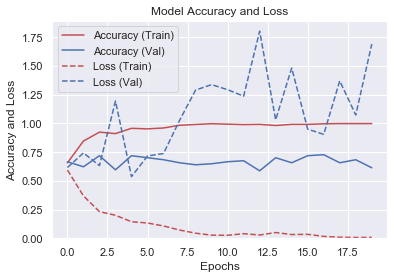

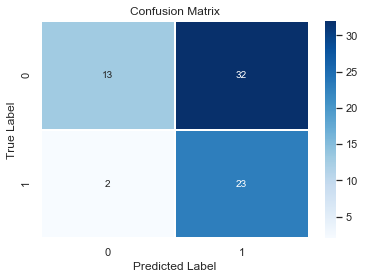

Accuracy Score (Test): 0.5143
Precision Score: 0.7065
Recall Score: 0.5143
F1 Score: 0.4839
Cohen Kappa Score: 0.1649
Matthews Corrcoef: 0.2439
ROC AUC Score: 0.6044
              precision    recall  f1-score   support

           0       0.87      0.29      0.43        45
           1       0.42      0.92      0.57        25

    accuracy                           0.51        70
   macro avg       0.64      0.60      0.50        70
weighted avg       0.71      0.51      0.48        70



In [15]:
y_pred_test = model3.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **InceptionV3 Model**

In [16]:
baseModel = InceptionV3(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dense(32, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model4 = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
    layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model4.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model4.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)

87916544/87910968 [==============================] - 18s 0us/step
Train on 510 samples, validate on 57 samples
Epoch 1/20
510/510 [==============================] - 26s 51ms/step - loss: 0.6774 - accuracy: 0.5490 - val_loss: 15.5991 - val_accuracy: 0.5614
Epoch 2/20
510/510 [==============================] - 24s 47ms/step - loss: 0.5992 - accuracy: 0.6735 - val_loss: 31.0430 - val_accuracy: 0.5614
Epoch 3/20
510/510 [==============================] - 24s 47ms/step - loss: 0.5591 - accuracy: 0.7196 - val_loss: 23.0583 - val_accuracy: 0.5614
Epoch 4/20
510/510 [==============================] - 24s 47ms/step - loss: 0.4804 - accuracy: 0.7696 - val_loss: 37.6763 - val_accuracy: 0.5614
Epoch 5/20
510/510 [==============================] - 24s 47ms/step - loss: 0.5604 - accuracy: 0.7176 - val_loss: 44.4863 - val_accuracy: 0.5614
Epoch 6/20
510/510 [==============================] - 24s 47ms/step - loss: 0.4585 - accuracy: 0.7971 - val_loss: 36.8486 - val_accuracy: 0.5614
Epoch 7/20
510/510 

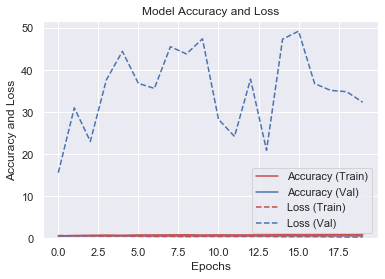

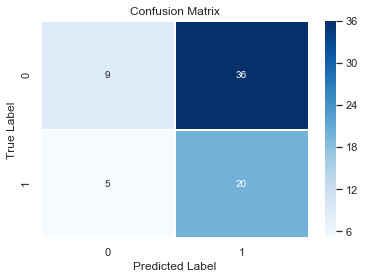

Accuracy Score (Test): 0.4143
Precision Score: 0.5408
Recall Score: 0.4143
F1 Score: 0.3725
Cohen Kappa Score: 0.0
Matthews Corrcoef: 0.0
ROC AUC Score: 0.5
              precision    recall  f1-score   support

           0       0.64      0.20      0.31        45
           1       0.36      0.80      0.49        25

    accuracy                           0.41        70
   macro avg       0.50      0.50      0.40        70
weighted avg       0.54      0.41      0.37        70



In [17]:
y_pred_test = model4.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **MobileNet Model**

In [18]:
baseModel = MobileNet(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dense(32, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model5 = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
    layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model5.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model5.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)

17227776/17225924 [==============================] - 5s 0us/step
Train on 510 samples, validate on 57 samples
Epoch 1/20
510/510 [==============================] - 24s 48ms/step - loss: 0.6618 - accuracy: 0.6206 - val_loss: 0.7030 - val_accuracy: 0.5439
Epoch 2/20
510/510 [==============================] - 24s 46ms/step - loss: 0.4816 - accuracy: 0.7765 - val_loss: 0.7151 - val_accuracy: 0.5351
Epoch 3/20
510/510 [==============================] - 24s 46ms/step - loss: 0.3483 - accuracy: 0.8618 - val_loss: 0.7245 - val_accuracy: 0.5614
Epoch 4/20
510/510 [==============================] - 23s 46ms/step - loss: 0.2520 - accuracy: 0.8951 - val_loss: 0.7537 - val_accuracy: 0.5439
Epoch 5/20
510/510 [==============================] - 23s 46ms/step - loss: 0.1777 - accuracy: 0.9392 - val_loss: 0.7935 - val_accuracy: 0.5439
Epoch 6/20
510/510 [==============================] - 24s 46ms/step - loss: 0.1230 - accuracy: 0.9588 - val_loss: 0.8969 - val_accuracy: 0.4737
Epoch 7/20
510/510 [======

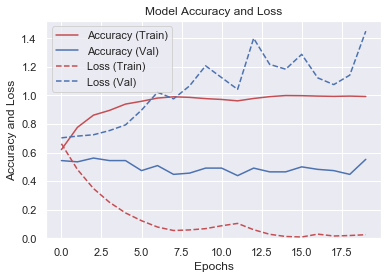

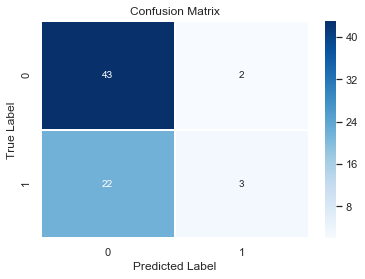

Accuracy Score (Test): 0.6571
Precision Score: 0.6396
Recall Score: 0.6571
F1 Score: 0.574
Cohen Kappa Score: 0.0919
Matthews Corrcoef: 0.1406
ROC AUC Score: 0.5378
              precision    recall  f1-score   support

           0       0.66      0.96      0.78        45
           1       0.60      0.12      0.20        25

    accuracy                           0.66        70
   macro avg       0.63      0.54      0.49        70
weighted avg       0.64      0.66      0.57        70



In [19]:
y_pred_test = model5.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **DenseNet169**

In [20]:
baseModel = DenseNet169(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dense(32, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model6 = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
    layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model6.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model6.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)

51879936/51877672 [==============================] - 14s 0us/step
Train on 510 samples, validate on 57 samples
Epoch 1/20
510/510 [==============================] - 122s 239ms/step - loss: 0.7027 - accuracy: 0.5412 - val_loss: 1.0919 - val_accuracy: 0.5526
Epoch 2/20
510/510 [==============================] - 116s 227ms/step - loss: 0.6087 - accuracy: 0.7157 - val_loss: 2.8585 - val_accuracy: 0.5614
Epoch 3/20
510/510 [==============================] - 116s 227ms/step - loss: 0.4802 - accuracy: 0.7941 - val_loss: 3.0820 - val_accuracy: 0.5614
Epoch 4/20
510/510 [==============================] - 115s 226ms/step - loss: 0.4355 - accuracy: 0.7833 - val_loss: 5.2807 - val_accuracy: 0.5614
Epoch 5/20
510/510 [==============================] - 116s 227ms/step - loss: 0.3327 - accuracy: 0.8588 - val_loss: 5.7907 - val_accuracy: 0.5614
Epoch 6/20
510/510 [==============================] - 116s 228ms/step - loss: 0.2454 - accuracy: 0.9255 - val_loss: 6.0459 - val_accuracy: 0.5614
Epoch 7/20
51

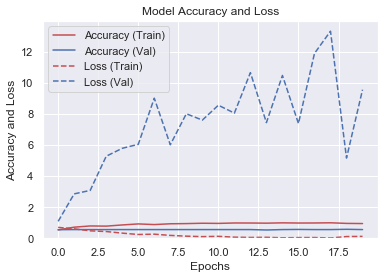

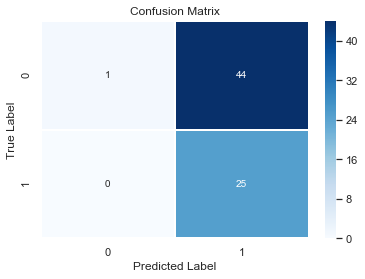

Accuracy Score (Test): 0.3714
Precision Score: 0.7723
Recall Score: 0.3714
F1 Score: 0.2179
Cohen Kappa Score: 0.016
Matthews Corrcoef: 0.0897
ROC AUC Score: 0.5111
              precision    recall  f1-score   support

           0       1.00      0.02      0.04        45
           1       0.36      1.00      0.53        25

    accuracy                           0.37        70
   macro avg       0.68      0.51      0.29        70
weighted avg       0.77      0.37      0.22        70



In [21]:
y_pred_test = model6.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **DenseNet 121**

In [22]:
baseModel = DenseNet121(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dense(32, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model7 = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
    layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model7.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model7.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)

29089792/29084464 [==============================] - 9s 0us/step
Train on 510 samples, validate on 57 samples
Epoch 1/20
510/510 [==============================] - 108s 212ms/step - loss: 0.6991 - accuracy: 0.5471 - val_loss: 0.9598 - val_accuracy: 0.5702
Epoch 2/20
510/510 [==============================] - 105s 205ms/step - loss: 0.6029 - accuracy: 0.6990 - val_loss: 1.7569 - val_accuracy: 0.5614
Epoch 3/20
510/510 [==============================] - 105s 205ms/step - loss: 0.5160 - accuracy: 0.7431 - val_loss: 3.8706 - val_accuracy: 0.5614
Epoch 4/20
510/510 [==============================] - 105s 205ms/step - loss: 0.4438 - accuracy: 0.8088 - val_loss: 7.8836 - val_accuracy: 0.5614
Epoch 5/20
510/510 [==============================] - 105s 205ms/step - loss: 0.4445 - accuracy: 0.7882 - val_loss: 6.6901 - val_accuracy: 0.5614
Epoch 6/20
510/510 [==============================] - 104s 205ms/step - loss: 0.4125 - accuracy: 0.8176 - val_loss: 7.6196 - val_accuracy: 0.5614
Epoch 7/20
510

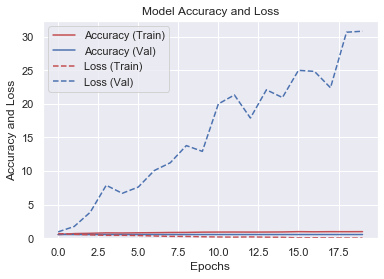

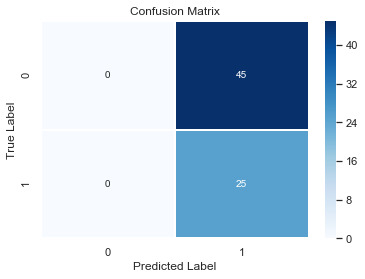

Accuracy Score (Test): 0.3571
Precision Score: 0.1276
Recall Score: 0.3571
F1 Score: 0.188
Cohen Kappa Score: 0.0
Matthews Corrcoef: 0.0
ROC AUC Score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.36      1.00      0.53        25

    accuracy                           0.36        70
   macro avg       0.18      0.50      0.26        70
weighted avg       0.13      0.36      0.19        70



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
y_pred_test = model7.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **Xception Model**

In [24]:
baseModel = Xception(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
    layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)

83689472/83683744 [==============================] - 23s 0us/step
Train on 510 samples, validate on 57 samples
Epoch 1/20
510/510 [==============================] - 82s 161ms/step - loss: 0.6612 - accuracy: 0.5951 - val_loss: 6.7469 - val_accuracy: 0.4649
Epoch 2/20
510/510 [==============================] - 81s 159ms/step - loss: 0.5324 - accuracy: 0.7549 - val_loss: 7.5044 - val_accuracy: 0.5439
Epoch 3/20
510/510 [==============================] - 81s 160ms/step - loss: 0.4767 - accuracy: 0.7902 - val_loss: 12.8150 - val_accuracy: 0.5526
Epoch 4/20
510/510 [==============================] - 82s 160ms/step - loss: 0.4031 - accuracy: 0.8294 - val_loss: 14.3758 - val_accuracy: 0.5526
Epoch 5/20
510/510 [==============================] - 81s 159ms/step - loss: 0.3792 - accuracy: 0.8588 - val_loss: 27.4496 - val_accuracy: 0.5614
Epoch 6/20
510/510 [==============================] - 81s 160ms/step - loss: 0.3421 - accuracy: 0.8647 - val_loss: 34.6816 - val_accuracy: 0.5614
Epoch 7/20
510/

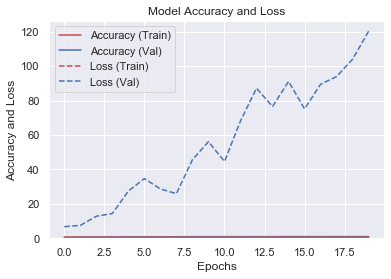

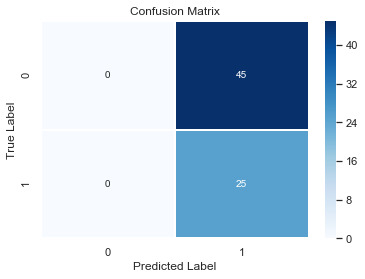

Accuracy Score (Test): 0.3571
Precision Score: 0.1276
Recall Score: 0.3571
F1 Score: 0.188
Cohen Kappa Score: 0.0
Matthews Corrcoef: 0.0
ROC AUC Score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.36      1.00      0.53        25

    accuracy                           0.36        70
   macro avg       0.18      0.50      0.26        70
weighted avg       0.13      0.36      0.19        70



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
y_pred_test = model.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **InceptionResNetV2 Model**

In [26]:
baseModel = InceptionResNetV2(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
    layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)

219062272/219055592 [==============================] - 51s 0us/step
Train on 510 samples, validate on 57 samples
Epoch 1/20
510/510 [==============================] - 124s 242ms/step - loss: 0.6180 - accuracy: 0.6569 - val_loss: 84.1256 - val_accuracy: 0.5614
Epoch 2/20
510/510 [==============================] - 116s 227ms/step - loss: 0.5076 - accuracy: 0.7725 - val_loss: 495.4308 - val_accuracy: 0.5614
Epoch 3/20
510/510 [==============================] - 116s 227ms/step - loss: 0.5318 - accuracy: 0.7441 - val_loss: 331.5180 - val_accuracy: 0.5614
Epoch 4/20
510/510 [==============================] - 117s 229ms/step - loss: 0.4674 - accuracy: 0.7696 - val_loss: 319.1171 - val_accuracy: 0.5614
Epoch 5/20
510/510 [==============================] - 116s 227ms/step - loss: 0.4138 - accuracy: 0.8078 - val_loss: 599.2265 - val_accuracy: 0.5614
Epoch 6/20
510/510 [==============================] - 115s 226ms/step - loss: 0.3852 - accuracy: 0.8520 - val_loss: 326.6980 - val_accuracy: 0.5614


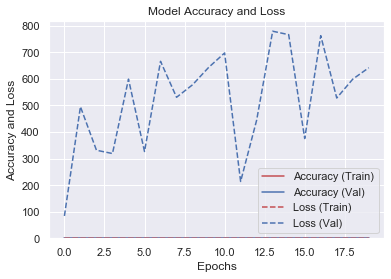

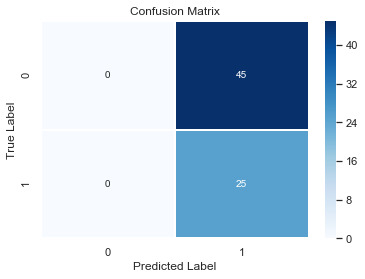

Accuracy Score (Test): 0.3571
Precision Score: 0.1276
Recall Score: 0.3571
F1 Score: 0.188
Cohen Kappa Score: 0.0
Matthews Corrcoef: 0.0
ROC AUC Score: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.36      1.00      0.53        25

    accuracy                           0.36        70
   macro avg       0.18      0.50      0.26        70
weighted avg       0.13      0.36      0.19        70



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
y_pred_test = model.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **ResNet Model**

In [28]:
baseModel = ResNet152(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
    layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)

234700800/234698864 [==============================] - 80s 0us/step
Train on 510 samples, validate on 57 samples
Epoch 1/20
510/510 [==============================] - 306s 601ms/step - loss: 0.6651 - accuracy: 0.6108 - val_loss: 1.4115 - val_accuracy: 0.4474
Epoch 2/20
510/510 [==============================] - 304s 596ms/step - loss: 0.4248 - accuracy: 0.8108 - val_loss: 0.5643 - val_accuracy: 0.6667
Epoch 3/20
510/510 [==============================] - 301s 591ms/step - loss: 0.3028 - accuracy: 0.8912 - val_loss: 0.5850 - val_accuracy: 0.7105
Epoch 4/20
510/510 [==============================] - 302s 592ms/step - loss: 0.2127 - accuracy: 0.9363 - val_loss: 0.7366 - val_accuracy: 0.6404
Epoch 5/20
510/510 [==============================] - 302s 593ms/step - loss: 0.1774 - accuracy: 0.9500 - val_loss: 0.5310 - val_accuracy: 0.7544
Epoch 6/20
510/510 [==============================] - 303s 594ms/step - loss: 0.1208 - accuracy: 0.9775 - val_loss: 0.5593 - val_accuracy: 0.7456
Epoch 7/20


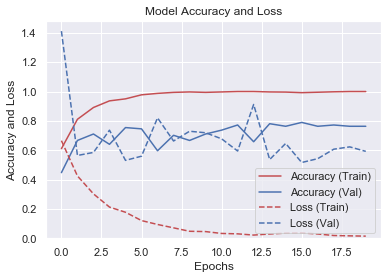

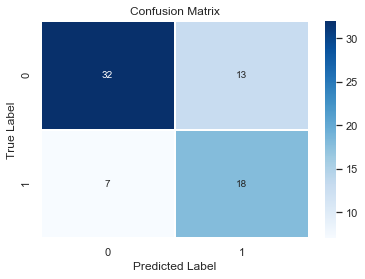

Accuracy Score (Test): 0.7143
Precision Score: 0.7348
Recall Score: 0.7143
F1 Score: 0.7194
Cohen Kappa Score: 0.4093
Matthews Corrcoef: 0.4159
ROC AUC Score: 0.7156
              precision    recall  f1-score   support

           0       0.82      0.71      0.76        45
           1       0.58      0.72      0.64        25

    accuracy                           0.71        70
   macro avg       0.70      0.72      0.70        70
weighted avg       0.73      0.71      0.72        70



In [29]:
y_pred_test = model.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **MobileNetV2 Model**

In [30]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
    layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)

9412608/9406464 [==============================] - 1s 0us/step
Train on 510 samples, validate on 57 samples
Epoch 1/20
510/510 [==============================] - 32s 63ms/step - loss: 0.6668 - accuracy: 0.6216 - val_loss: 0.9528 - val_accuracy: 0.5526
Epoch 2/20
510/510 [==============================] - 30s 60ms/step - loss: 0.4272 - accuracy: 0.7971 - val_loss: 0.9483 - val_accuracy: 0.5526
Epoch 3/20
510/510 [==============================] - 31s 60ms/step - loss: 0.4040 - accuracy: 0.8108 - val_loss: 0.8649 - val_accuracy: 0.5439
Epoch 4/20
510/510 [==============================] - 31s 60ms/step - loss: 0.2830 - accuracy: 0.8804 - val_loss: 1.1779 - val_accuracy: 0.5614
Epoch 5/20
510/510 [==============================] - 31s 60ms/step - loss: 0.2522 - accuracy: 0.9078 - val_loss: 1.3030 - val_accuracy: 0.5614
Epoch 6/20
510/510 [==============================] - 31s 60ms/step - loss: 0.2122 - accuracy: 0.9265 - val_loss: 1.7427 - val_accuracy: 0.5614
Epoch 7/20
510/510 [========

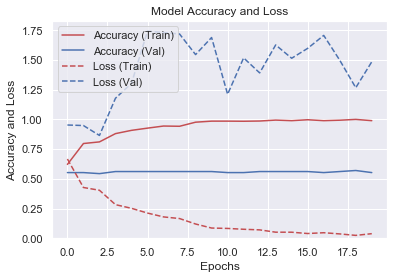

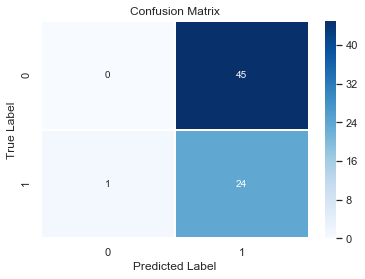

Accuracy Score (Test): 0.3429
Precision Score: 0.1242
Recall Score: 0.3429
F1 Score: 0.1824
Cohen Kappa Score: -0.0288
Matthews Corrcoef: -0.1615
ROC AUC Score: 0.48
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.35      0.96      0.51        25

    accuracy                           0.34        70
   macro avg       0.17      0.48      0.26        70
weighted avg       0.12      0.34      0.18        70



In [31]:
y_pred_test = model.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### ResNet 101

In [38]:
baseModel = ResNet101(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
    layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)

171450368/171446536 [==============================] - 43s 0us/step
Train on 510 samples, validate on 57 samples
Epoch 1/20
510/510 [==============================] - 226s 444ms/step - loss: 0.6848 - accuracy: 0.6431 - val_loss: 0.5507 - val_accuracy: 0.7193
Epoch 2/20
510/510 [==============================] - 235s 461ms/step - loss: 0.3702 - accuracy: 0.8343 - val_loss: 0.7881 - val_accuracy: 0.6667
Epoch 3/20
510/510 [==============================] - 229s 449ms/step - loss: 0.2726 - accuracy: 0.8912 - val_loss: 0.9053 - val_accuracy: 0.6579
Epoch 4/20
510/510 [==============================] - 226s 442ms/step - loss: 0.2481 - accuracy: 0.9039 - val_loss: 2.0930 - val_accuracy: 0.5614
Epoch 5/20
510/510 [==============================] - 227s 445ms/step - loss: 0.2085 - accuracy: 0.9108 - val_loss: 1.8383 - val_accuracy: 0.5789
Epoch 6/20
510/510 [==============================] - 228s 447ms/step - loss: 0.1250 - accuracy: 0.9765 - val_loss: 2.5304 - val_accuracy: 0.5702
Epoch 7/20


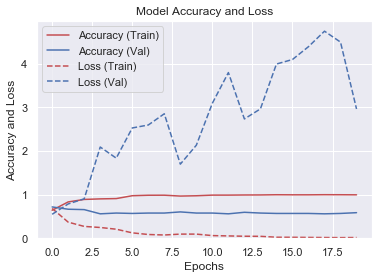

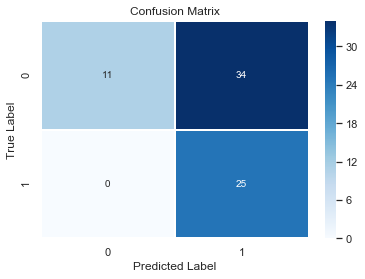

Accuracy Score (Test): 0.5143
Precision Score: 0.7942
Recall Score: 0.5143
F1 Score: 0.4651
Cohen Kappa Score: 0.1877
Matthews Corrcoef: 0.3218
ROC AUC Score: 0.6222
              precision    recall  f1-score   support

           0       1.00      0.24      0.39        45
           1       0.42      1.00      0.60        25

    accuracy                           0.51        70
   macro avg       0.71      0.62      0.49        70
weighted avg       0.79      0.51      0.47        70



In [39]:
y_pred_test = model.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()